# One-shot learning implementation for fish recognition
Using the [fish4knowledge Fish Recognition Ground-Truth dataset](https://github.com/brendenlake/omniglot/tree/master/python)

### TODO
- entrainer sans negatif ?
- normalization des entrées (pour same ?)
- data augmentation ?
- comparer avec et sans
  - batch norm
  - batch norm au début
  - dropout
  - regul

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Setup phase
We install packages, make all imports, configure modules and download dataset

In [2]:
%%bash
pip install -q pyyaml
pip install tensorflow==2.0.0-beta1
pip install -q tensorflow-gpu==2.0.0-beta1

  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [3]:
%%bash
mkdir datas
ls "/content/drive/My Drive/ml/datas"
unzip -q "/content/drive/My Drive/ml/datas/fishdb.zip" -d datas

fishdb.zip
fishes_all_augmented.zip
fishes_all.zip
fishes_one_shot.zip
fishes_species.zip
taiwan_db.zip


In [4]:
%load_ext tensorboard

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import pandas as pd
import numpy as np
import skimage
from skimage import transform as sktrans

from tensorflow.keras import layers
from tensorflow.keras import datasets, layers, models
from tensorboard import notebook
from keras import backend as K
from IPython import display

import os, datetime, time, math, pathlib, itertools, random

keras = tf.keras
AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.version.VERSION)
print(tf.keras.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

2.0.0-beta1
2.2.4-tf
GPU Available:  True


## Constants
This part will define how to build, train, and evaluate the model

In [0]:
#@markdown ## Data paths
DIR_DATAS = "datas/fishdb" #@param {type:"string"}
DIR_DATA_TEST = "datas/fishes_one_shot" #@param {type:"string"}

#@markdown ## Model configuration
IMG_SIDE = 96 #@param {type:"slider", min:10, max:300, step:1}
IMG_SHAPE = (IMG_SIDE, IMG_SIDE, 3)

#@markdown ## Evaluation configuration
ACCURACY_SAMPLE_SIZE = 500 #@param {type:"number"}
KEEP_TO_TRAIN = 10

## General code
Helper functions

In [0]:
def getRandomIds(dataset, nMax=1000):
	ids = list(range(len(dataset[0][0])-1))
	random.shuffle(ids)
	ids = ids[:nMax]
	return ids + [i+1 for i in ids]

In [0]:
  def dist_fct(x, y):
    return np.sqrt(np.sum((x-y)**2))

In [0]:
def get_checkpoint_path(suffix=""):
  os.makedirs(os.path.join(CHECKPOINTS_DIR, checkpoint_dir_name), exist_ok=True)
  return os.path.join(
    CHECKPOINTS_DIR,
    checkpoint_dir_name,
    "weights" + suffix + ".hdf5"
  )

In [0]:
class Timer():
  def __init__(self, to_int = True):
    self.t = time.time()
    self.to_int = to_int
  
  def get(self, reset=True):
    t2 = time.time()
    d = t2 - self.t
    if self.to_int:
      d = int(d)
    if reset:
      self.t = t2
    return d

In [0]:
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])

In [0]:
def show_image(image):
	plt.imshow(image)
	plt.show()

## Import datas and pre-processing

In [0]:
def img_to_rgb(image):
  if len(image.shape) == 3 and image.shape[2] == 3:
    return image
  if len(image.shape) == 3:
    image = image.reshape(image.shape[:2])
  return skimage.color.grey2rgb(image)

def reshape_image(image):
  h, w = image.shape[0], image.shape[1]
  scale = min(IMG_SHAPE[0]/h, IMG_SHAPE[1]/w)
  padH = round((IMG_SHAPE[0] / scale - h) / 2)
  padW = round((IMG_SHAPE[1] / scale - w) / 2)

  padShape = ((padH, padH), (padW, padW), (0,0))
  image = skimage.util.pad(image, padShape, 'constant')

  return skimage.transform.resize(image, IMG_SHAPE, mode='symmetric', preserve_range=True)

def preprocess_image(tf_image):
  tf_image = tf.image.decode_image(tf_image)
  # tf_image = tf.image.resize(tf_image, IMG_SHAPE)
  image = tf_image.numpy().astype(float).reshape(tf_image.shape) / 255.0
  image = img_to_rgb(image)
  image = reshape_image(image)
  return image

def load_and_preprocess_image(img_path):
  return preprocess_image(tf.io.read_file(str(img_path)))

In [0]:
def list_dir_files(path):
  return [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

def get_datas_paths(dir_path):
  fish_classes = sorted(list(os.listdir(dir_path)))
  fish_dirs = [os.path.join(dir_path, cls) for cls in fish_classes]
  # TODO : subdirs
  img_infos = [
      [(os.path.join(cls_path, img_f_name), label) for img_f_name in list_dir_files(cls_path)]
      for cls_path, label in zip(fish_dirs, list(range(len(fish_dirs))))
  ]
  img_infos = list(itertools.chain(*img_infos))
  paths, labels = [[el[i] for el in img_infos] for i in range(2)]
  return paths, labels, fish_classes # len : nb images | nb images | nb classes

def load_datas(dir_path):
  paths, labels, cls_names = get_datas_paths(dir_path)
  images_datas = [load_and_preprocess_image(img_path) for img_path in paths]
  images_datas, labels = np.array(images_datas), np.array(labels)
  return images_datas, labels, cls_names

def get_subsets_per_cls(datas, labels, subsets=[None]):
  nb_cls = max(labels)+1
  subsets_datas = [[() for _ in subsets] for _ in range(nb_cls)]
  ids_per_cls = [[] for _ in range(nb_cls)]
  for i in range(len(datas)):
    ids_per_cls[labels[i]].append(i)
  
  for i_cls in range(nb_cls):
    for i_sub, max_datas in enumerate(subsets):
      if max_datas == None:
        max_datas = len(ids_per_cls[i_cls])
      subsets_datas[i_cls][i_sub] = ids_per_cls[i_cls][:max_datas]
      ids_per_cls[i_cls] = ids_per_cls[i_cls][max_datas:]
  split_datas = [([], []) for _ in subsets]
  for i_cls in range(nb_cls):
    for i_sub in range(len(subsets)):
      for i_img in subsets_datas[i_cls][i_sub]:
        split_datas[i_sub][0].append(datas[i_img])
        split_datas[i_sub][1].append(labels[i_img])
  split_datas = [(np.array(a1), np.array(a2)) for (a1, a2) in split_datas]
  return split_datas

Now, we read all the datas

In [0]:
try:
  _ = train_images
except:
  all_images, all_labels, train_cls_names = load_datas(DIR_DATAS)
  test_cls_names = train_cls_names
  (train_images, train_labels), (test_images, test_labels) = get_subsets_per_cls(all_images, all_labels, (KEEP_TO_TRAIN, None))

## Prediction and evaluation models and functions

In [0]:
class NearestPredictor:
  def __init__(self, datas=([], [])):
    self.set_datas(datas)
  
  def set_datas(self, datas):
    self.images, self.labels = datas
  
  def build(self):
    self.img_coords = np.array(self.images)

  def predict_in_datas(self, i):
    dists = [dist_fct(self.img_coords[i], coord) for coord in self.img_coords]
    dists[i] = max(dists) * 2 + 1
    return self.labels[np.argmin(dists)]

  def predict(self, image):
    predict_coords = np.array([image])
    dists = [dist_fct(predict_coords, coord) for coord in self.img_coords]
    return self.labels[np.argmin(dists)]


In [0]:
def evaluate_accuracy_in_datas(predict_obj, ids_sample):
  good_results = [i for i in ids_sample if predict_obj.labels[i] == predict_obj.predict_in_datas(i)]
  return (len(good_results) / len(ids_sample), good_results)

def evaluate_accuracy(predict_obj, datas, labels, ids_sample=None):
  if ids_sample == None:
    ids_sample = list(range(len(datas)))
  good_results = [i for i in ids_sample if labels[i] == predict_obj.predict(datas[i])]
  return (len(good_results) / len(ids_sample), good_results)

In [0]:
def evaluate_accuracy_train_datas():
  return evaluate_accuracy_in_datas(predict, train_datas_sample)

def evaluate_accuracy_test_datas():
  return evaluate_accuracy_in_datas(predict_testing, test_datas_sample)


In [0]:
def random_sample_homogeneous(labels, sample_size):
  nb_cls = max(labels)+1
  ids_of_cls = [[] for _ in range(nb_cls)]
  for i, cls in enumerate(labels):
    ids_of_cls[cls].append(i)
  
  per_cls = sample_size // nb_cls
  taken, not_taken = [], []
  for ids in ids_of_cls:
    random.shuffle(ids)
    taken.extend(ids[:per_cls])
    not_taken.extend(ids[per_cls:])
  if len(taken) < sample_size:
    taken.extend(random.sample(not_taken, sample_size-len(taken)))
  return taken

predict = NearestPredictor((train_images, train_labels))
predict_testing = NearestPredictor((test_images, test_labels))

train_datas_sample = random.sample(list(range(len(train_labels))), ACCURACY_SAMPLE_SIZE)
test_datas_sample = random.sample(list(range(len(test_labels))), ACCURACY_SAMPLE_SIZE)

## Functions to compute / plot stats about trained models

In [0]:
def eval_dists_on_sample(predict_obj, ids_sample):
  same_dists, diff_dists = [], []

  for i in ids_sample:
    i_cls, i_coord = predict_obj.labels[i], predict_obj.img_coords[i]
    for j, j_coord in enumerate(predict_obj.img_coords):
      if i != j:
        if i_cls == predict_obj.labels[j]:
          same_dists.append(dist_fct(i_coord, j_coord))
        else:
          diff_dists.append(dist_fct(i_coord, j_coord))
  return same_dists, diff_dists

In [0]:
def plot_hist(arrs):
  plt.figure(figsize=(12,5))
  plt.hist(arrs,
    bins = 60,
    color = ['blue', '#D72F1A'],
    # edgecolor = 'black',
    label=["Same dists", "Diff dists"],
    density=True
  )
  plt.legend(loc='upper right')

  plt.tight_layout()
  plt.show()

In [0]:
def plot_results_per_class(good_results, labels, cls_names, sample=None):
  n_cls = len(cls_names)
  cls_success, cls_failed = [0]*n_cls, [0]*n_cls

  if n_cls > 60:
    plt.figure(figsize=(35,6))
  else:
    plt.figure(figsize=(15,6))

  is_success = [False] * len(labels)
  if sample:
    is_success = [None] * len(labels) # None stand for unused
    for i in sample:
      is_success[i] = False
  
  for i in good_results:
    is_success[i] = True

  for i, succ in enumerate(is_success):
    if succ == True:
      cls_success[labels[i]] += 1
    elif succ == False:
      cls_failed[labels[i]] += 1
  
  ind = np.arange(n_cls)
  width = 0.8 # the width of the bars: can also be len(x) sequence
  rotation = 45 if n_cls < 60 else 90

  p1 = plt.bar(ind, cls_success, width, color="#4CAF50")
  p2 = plt.bar(ind, cls_failed, width, bottom=cls_success, color="#EF5350")

  plt.ylabel('Number of tests')
  plt.xlabel('Fish species')
  plt.title('Number of detection success and failure per fish species')
  plt.xticks(ind, cls_names, rotation=rotation)
  # plt.yticks(np.arange(0, 81, 10))
  plt.legend((p1[0], p2[0]), ('Success', 'Failed'))

  plt.show()

## Display trained model stats

===== TRAINING STATS =====
Build 1
6296 500
Build 2
Accuracy : 4.3999999999999995%
Avg dist same class : 41.78322322343221
Avg dist distinct classes : 46.19346845401534


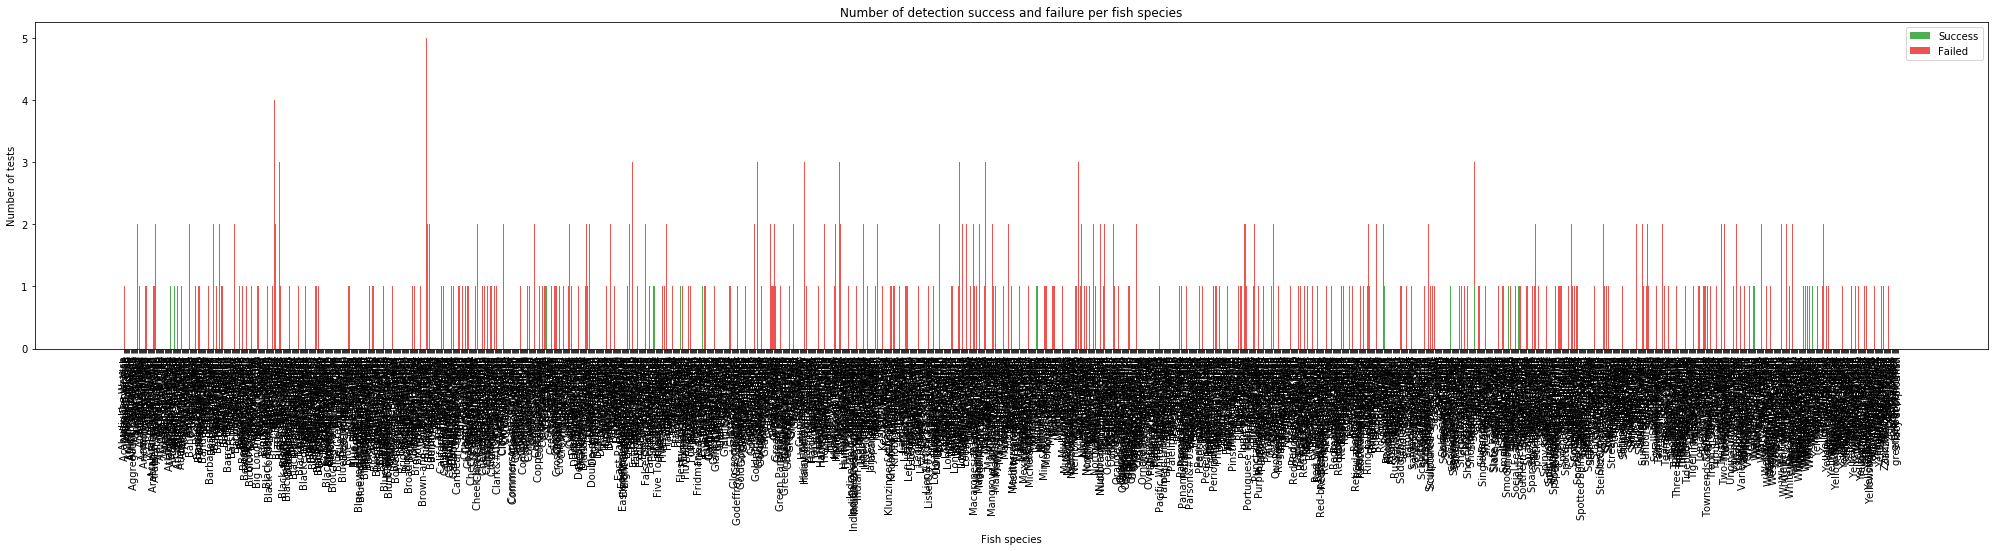

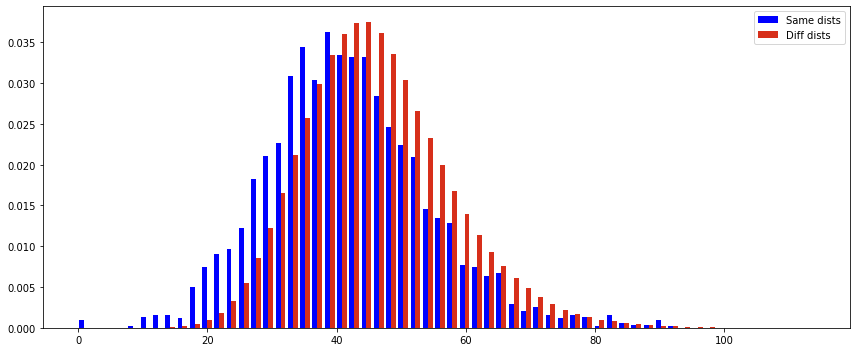

6296 500 3148000
2743 3144757
CPU times: user 6min 4s, sys: 2.14 s, total: 6min 6s
Wall time: 6min 6s


In [34]:
%%time
print("===== TRAINING STATS =====")
predict.build()
print("Build 1")
print("tailles", len(predict.img_coords), len(train_datas_sample))
same_dists, diff_dists = eval_dists_on_sample(predict, train_datas_sample)
print("Build 2")
accuracy, good_results = evaluate_accuracy_train_datas()

print("Accuracy : {}%".format(accuracy*100))
print("Avg dist same class :", sum(same_dists) / len(same_dists))
print("Avg dist distinct classes :", sum(diff_dists) / len(diff_dists))

plot_results_per_class(good_results, train_labels, train_cls_names, sample=train_datas_sample)
plot_hist([same_dists, diff_dists])
print(len(train_images), ACCURACY_SAMPLE_SIZE, ACCURACY_SAMPLE_SIZE * len(train_images))
print(len(same_dists), len(diff_dists))

===== TESTING WITHIN SAME DATAS STATS =====
Accuracy : 3.0%
Avg dist same class : 43.271456659234246
Avg dist distinct classes : 44.533061903637865


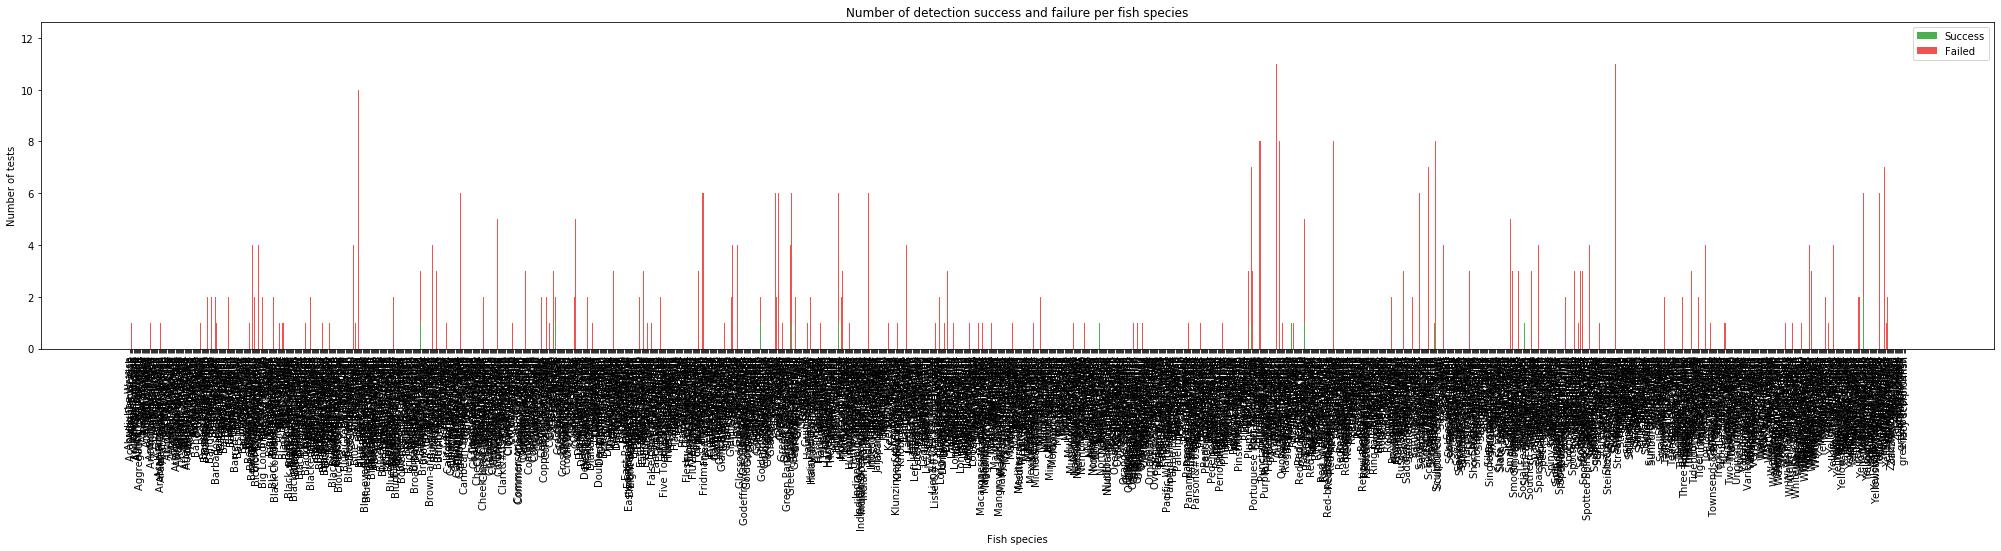

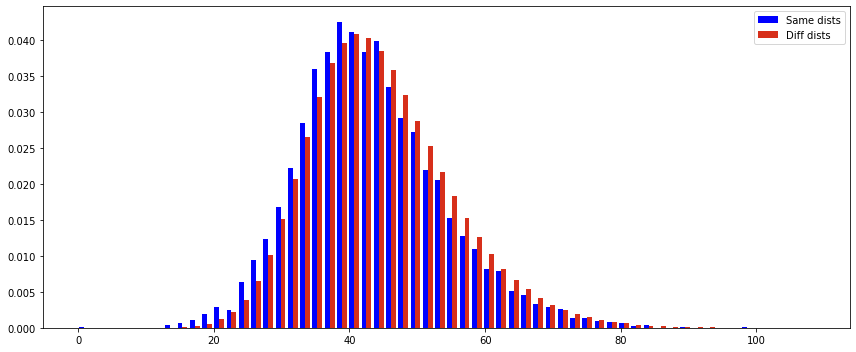

CPU times: user 2min 25s, sys: 1.75 s, total: 2min 27s
Wall time: 2min 27s


In [35]:
%%time
print("===== TESTING WITHIN SAME DATAS STATS =====")
predict_testing.build()
same_dists, diff_dists = eval_dists_on_sample(predict_testing, test_datas_sample)
accuracy, good_results = evaluate_accuracy_test_datas()

print("Accuracy : {}%".format(accuracy*100))
print("Avg dist same class :", sum(same_dists) / len(same_dists))
print("Avg dist distinct classes :", sum(diff_dists) / len(diff_dists))

plot_results_per_class(good_results, test_labels, test_cls_names, sample=test_datas_sample)
plot_hist([same_dists, diff_dists])

In [0]:
# %%time
# print("===== TESTING WITH DIFFERENT DATAS STATS =====")
# predict_base.build()
# # same_dists, diff_dists = eval_dists_on_sample(predict_base, test_datas_sample)

# accuracy, good_results = evaluate_accuracy(predict_base, test_images, test_labels)
# print("Accuracy : {}%".format(accuracy*100))
# plot_results_per_class(good_results, test_labels, test_cls_names)

# # print("Avg dist same class :", sum(same_dists) / len(same_dists))
# # print("Avg dist distinct classes :", sum(diff_dists) / len(diff_dists))
# # plot_hist([same_dists, diff_dists])

In [0]:
# %matplotlib inline

# for _ in range(3):
#     try:
#         pl.clf()
#         pl.plot(pd.Series(data=np.random.randn(100), index=i))
#         display.display(pl.gcf())
#         display.clear_output(wait=True)
#         time.sleep(1)
#     except KeyboardInterrupt:
#         break